In [1]:
# ============================================================================
# 02_STAGE1_TRAINING.IPYNB
# ============================================================================
# PURPOSE: Train binary UNSAFE detector (Stage 1 of cascade)
# MODEL: RoBERTa-base with Focal Loss
# TARGET: 85%+ UNSAFE recall on validation set
# TIME ESTIMATE: 2-3 hours with 1x B200 GPU
# GPU USAGE: Will use 1 GPU (can parallelize with multiple GPUs if available)
# ============================================================================

# Stage 1: UNSAFE Content Detector

## Objective
Train a specialized binary classifier to detect UNSAFE content with extremely high recall.

## Strategy
- Model: RoBERTa-base (125M parameters, excellent for text classification)
- Loss: Focal Loss with high gamma (focuses on hard examples)
- Class weight: UNSAFE = 4.0 (heavy penalty for missing UNSAFE content)
- Target: 85%+ UNSAFE recall (we'll tune threshold later to reach 90%+)

## Why Two-Stage Cascade?
- Stage 1 specializes in one critical task: catching UNSAFE content
- Simpler binary task = better performance on minority class
- Can optimize specifically for high recall without worrying about SAFE/SENSITIVE distinction

## 1. Setup and Imports

In [2]:
import torch

In [ ]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    classification_report, confusion_matrix, 
    precision_recall_curve, roc_auc_score, roc_curve
)
import warnings
warnings.filterwarnings('ignore')

notebook_dir = os.getcwd()
PROJECT_ROOT = os.path.abspath(os.path.join(notebook_dir, '..'))

# PyTorch and Transformers
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from transformers import (
    RobertaTokenizer, RobertaForSequenceClassification,
    AdamW, get_linear_schedule_with_warmup
)

from tqdm.auto import tqdm
import random, pickle

# state = {
#     "python_random_state": random.getstate(),
#     "numpy_random_state": np.random.get_state(),
#     "torch_seed": torch.initial_seed()
# }

# with open("rng_state.pkl", "wb") as f:
#     pickle.dump(state, f)
    
# print("Seed: ", state["torch_seed"])

# Set random seeds for reproducibility
RANDOM_SEED = 1203578326
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(RANDOM_SEED)

# Check GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
    # For B200, you should see ~80GB memory
else:
    print("WARNING: No GPU detected. Training will be very slow!")

# Create results directory
os.makedirs(os.path.join(PROJECT_ROOT, 'results', 'stage1'), exist_ok=True)
os.makedirs(os.path.join(PROJECT_ROOT, 'models', 'stage1_unsafe_detector'), exist_ok=True)

print("\n✓ Setup complete")

Using device: cuda
GPU: NVIDIA B200
GPU Memory: 191.51 GB

✓ Setup complete


## 2. Configuration

**Hyperparameters explained:**
- **MAX_LENGTH=512**: RoBERTa's maximum token limit (our 400-word articles fit easily)
- **BATCH_SIZE=16**: Balance between speed and memory (B200 can handle 32-64, but 16 is safe)
- **LEARNING_RATE=2e-5**: Standard for fine-tuning transformers (too high = unstable, too low = slow)
- **EPOCHS=5**: Usually 3-5 epochs sufficient for fine-tuning (more = overfitting risk)
- **WARMUP_RATIO=0.1**: Gradually increase LR for first 10% of steps (stabilizes training)
- **WEIGHT_DECAY=0.01**: L2 regularization to prevent overfitting

In [4]:
# Model configuration
CONFIG = {
    'model_name': 'roberta-base',  # 125M parameters, great balance of speed/performance
    'max_length': 512,              # Maximum token sequence length
    'batch_size': 16,               # Batch size per GPU (increase to 32 if memory allows)
    'learning_rate': 1e-5,          # Learning rate for AdamW optimizer
    'epochs': 4,                    # Number of training epochs
    'warmup_ratio': 0.1,            # Warmup steps as fraction of total steps
    'weight_decay': 0.01,           # L2 regularization
    'focal_loss_gamma': 3,          # Focal loss focusing parameter (higher = more focus on hard examples)
    'focal_loss_alpha': [1.0, 4.0], # Class weights: [NOT_UNSAFE, UNSAFE]
    'gradient_accumulation_steps': 1, # Accumulate gradients (set to 2-4 if OOM)
    'max_grad_norm': 1.0,           # Gradient clipping to prevent exploding gradients
    'save_steps': 500,              # Save checkpoint every N steps
    'eval_steps': 500,              # Evaluate every N steps
    'early_stopping_patience': 1    # Stop if no improvement for N evaluations
}

print("Configuration:")
print(json.dumps(CONFIG, indent=2))

# Calculate steps
# Will be updated after loading data
print("\n(Step counts will be calculated after loading data)")

Configuration:
{
  "model_name": "roberta-base",
  "max_length": 512,
  "batch_size": 16,
  "learning_rate": 1e-05,
  "epochs": 4,
  "warmup_ratio": 0.1,
  "weight_decay": 0.01,
  "focal_loss_gamma": 3,
  "focal_loss_alpha": [
    1.0,
    4.0
  ],
  "gradient_accumulation_steps": 1,
  "max_grad_norm": 1.0,
  "save_steps": 500,
  "eval_steps": 500,
  "early_stopping_patience": 1
}

(Step counts will be calculated after loading data)


## 3. Load Datasets

**What we're loading:**
- Training: 6,925 samples (binary labels: UNSAFE vs NOT_UNSAFE)
- Validation: 1,484 samples (for monitoring during training)
- Metadata: Class weights calculated in Notebook 01

In [5]:
print("\n" + "="*80)
print("LOADING DATASETS")
print("="*80)

# Load datasets
train_df = pd.read_csv(os.path.join(PROJECT_ROOT, 'data', 'processed', 'train_stage1.csv'))
val_df = pd.read_csv(os.path.join(PROJECT_ROOT, 'data', 'processed', 'val_stage1.csv'))
test_df = pd.read_csv(os.path.join(PROJECT_ROOT, 'data', 'processed', 'test_stage1.csv'))

print(f"Train: {len(train_df)} samples")
print(f"Val: {len(val_df)} samples")
print(f"Test: {len(test_df)} samples")

print("\nTrain label distribution:")
print(train_df['binary_label'].value_counts())
print("\nVal label distribution:")
print(val_df['binary_label'].value_counts())

# Load metadata with class weights
with open(os.path.join(PROJECT_ROOT, 'data', 'processed', 'metadata.json'), 'r') as f:
    metadata = json.load(f)

print("\nClass weights (from metadata):")
print(f"  NOT_UNSAFE: {metadata['stage1_weights_boosted']['NOT_UNSAFE']:.2f}")
print(f"  UNSAFE: {metadata['stage1_weights_boosted']['UNSAFE']:.2f}")

print("\n→ UNSAFE weight = 4.0 means: 'Misclassifying UNSAFE is 4x worse'")
print("→ This biases model toward high UNSAFE recall")


LOADING DATASETS


Train: 4947 samples
Val: 1060 samples
Test: 1061 samples

Train label distribution:
binary_label
NOT_UNSAFE    4057
UNSAFE         890
Name: count, dtype: int64

Val label distribution:
binary_label
NOT_UNSAFE    868
UNSAFE        192
Name: count, dtype: int64

Class weights (from metadata):
  NOT_UNSAFE: 0.61
  UNSAFE: 4.00

→ UNSAFE weight = 4.0 means: 'Misclassifying UNSAFE is 4x worse'
→ This biases model toward high UNSAFE recall


## 4. Create Label Encodings

**Label mapping:**
- NOT_UNSAFE → 0
- UNSAFE → 1

**Why?** PyTorch expects integer labels, not strings

In [6]:
# Create label encoding
label2id = {'NOT_UNSAFE': 0, 'UNSAFE': 1}
id2label = {0: 'NOT_UNSAFE', 1: 'UNSAFE'}

print("Label encoding:")
print(f"  NOT_UNSAFE → {label2id['NOT_UNSAFE']}")
print(f"  UNSAFE → {label2id['UNSAFE']}")

# Add encoded labels to dataframes
train_df['label_id'] = train_df['binary_label'].map(label2id)
val_df['label_id'] = val_df['binary_label'].map(label2id)
test_df['label_id'] = test_df['binary_label'].map(label2id)

# Verify encoding
assert train_df['label_id'].isnull().sum() == 0, "ERROR: Label encoding failed!"
print("\n✓ Labels encoded successfully")

Label encoding:
  NOT_UNSAFE → 0
  UNSAFE → 1

✓ Labels encoded successfully


## 5. Initialize Tokenizer

**What is tokenization?**
- Converts text into numbers (token IDs) that the model understands
- "The cat sat" → [133, 4758, 2067]
- Also handles padding, truncation, attention masks

**RoBERTa tokenizer:**
- Uses byte-pair encoding (BPE)
- Vocabulary size: 50,265 tokens
- Handles subwords (e.g., "unhappiness" → "un", "happiness")

In [7]:
print("\n" + "="*80)
print("INITIALIZING TOKENIZER")
print("="*80)

tokenizer = RobertaTokenizer.from_pretrained(CONFIG['model_name'])

print(f"Tokenizer: {CONFIG['model_name']}")
print(f"Vocab size: {len(tokenizer)}")
print(f"Max length: {CONFIG['max_length']}")

# Test tokenization
sample_text = train_df['text'].iloc[0][:200]
tokens = tokenizer.tokenize(sample_text)
print(f"\nSample text: {sample_text}")
print(f"Tokens (first 20): {tokens[:20]}")
print(f"Token count: {len(tokens)}")

print("\n✓ Tokenizer ready")


INITIALIZING TOKENIZER
Tokenizer: roberta-base
Vocab size: 50265
Max length: 512

Sample text: Supreme Court Justice Clarence Thomas recused himself for the first time from a matter regarding the January 6, 2021 Capitol attack. The conservative justice's decision to withdraw his voice from the 
Tokens (first 20): ['Sup', 'reme', 'ĠCourt', 'ĠJustice', 'ĠClarence', 'ĠThomas', 'Ġrec', 'used', 'Ġhimself', 'Ġfor', 'Ġthe', 'Ġfirst', 'Ġtime', 'Ġfrom', 'Ġa', 'Ġmatter', 'Ġregarding', 'Ġthe', 'ĠJanuary', 'Ġ6']
Token count: 37

✓ Tokenizer ready


## 6. Create PyTorch Dataset Class

**Purpose:** Wrap our data for efficient batching and GPU transfer

**What it does:**
1. Takes a row of data (text + label)
2. Tokenizes the text
3. Returns tensors ready for model input

**Tokenizer output:**
- `input_ids`: Token IDs [133, 4758, 2067, ...]
- `attention_mask`: Which tokens are real vs padding [1, 1, 1, 0, 0, ...]

In [8]:
class NewsDataset(Dataset):
    """
    PyTorch Dataset for news article classification.
    
    Args:
        texts: List of article texts (strings)
        labels: List of label IDs (integers: 0 or 1)
        tokenizer: Hugging Face tokenizer
        max_length: Maximum sequence length
    """
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        
        # Tokenize text
        encoding = self.tokenizer(
            text,
            add_special_tokens=True,      # Add [CLS] and [SEP] tokens
            max_length=self.max_length,   # Truncate if longer
            padding='max_length',          # Pad if shorter
            truncation=True,               # Enable truncation
            return_attention_mask=True,    # Return attention mask
            return_tensors='pt'            # Return PyTorch tensors
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Create datasets
train_dataset = NewsDataset(
    texts=train_df['text'].values,
    labels=train_df['label_id'].values,
    tokenizer=tokenizer,
    max_length=CONFIG['max_length']
)

val_dataset = NewsDataset(
    texts=val_df['text'].values,
    labels=val_df['label_id'].values,
    tokenizer=tokenizer,
    max_length=CONFIG['max_length']
)

print(f"\nTrain dataset: {len(train_dataset)} samples")
print(f"Val dataset: {len(val_dataset)} samples")

# Test dataset
sample = train_dataset[0]
print(f"\nSample batch item:")
print(f"  input_ids shape: {sample['input_ids'].shape}")
print(f"  attention_mask shape: {sample['attention_mask'].shape}")
print(f"  label: {sample['labels'].item()} ({id2label[sample['labels'].item()]})")

print("\n✓ Datasets created")


Train dataset: 4947 samples
Val dataset: 1060 samples

Sample batch item:
  input_ids shape: torch.Size([512])
  attention_mask shape: torch.Size([512])
  label: 0 (NOT_UNSAFE)

✓ Datasets created


## 7. Create DataLoaders

**Purpose:** Efficiently load batches during training

**DataLoader features:**
- Batching: Groups samples into batches of size 16
- Shuffling: Randomizes order each epoch (prevents overfitting to sequence)
- Multiprocessing: Loads data in parallel (num_workers=4)
- Pin memory: Faster GPU transfer

**Why shuffle train but not val?**
- Train: Random order prevents memorization
- Val: Consistent order for reproducible metrics

In [9]:
from torch.utils.data import DataLoader

# Create data loaders
train_loader = DataLoader(
    train_dataset,
    batch_size=CONFIG['batch_size'],
    shuffle=True,           # Shuffle training data each epoch
    num_workers=4,          # Parallel data loading (adjust based on CPU cores)
    pin_memory=True         # Faster GPU transfer
)

val_loader = DataLoader(
    val_dataset,
    batch_size=CONFIG['batch_size'],
    shuffle=False,          # Don't shuffle validation data
    num_workers=4,
    pin_memory=True
)

print(f"\nTrain batches per epoch: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")

# Calculate total training steps
total_steps = len(train_loader) * CONFIG['epochs']
warmup_steps = int(total_steps * CONFIG['warmup_ratio'])

print(f"\nTraining schedule:")
print(f"  Total steps: {total_steps}")
print(f"  Warmup steps: {warmup_steps}")
print(f"  Steps per epoch: {len(train_loader)}")

print("\n✓ DataLoaders ready")


Train batches per epoch: 310
Val batches: 67

Training schedule:
  Total steps: 1240
  Warmup steps: 124
  Steps per epoch: 310

✓ DataLoaders ready


## 8. Define Focal Loss

**What is Focal Loss?**
- Addresses class imbalance by focusing on hard-to-classify examples
- Standard cross-entropy treats all examples equally
- Focal loss down-weights easy examples, up-weights hard examples

**Formula:**
```
FL(pt) = -α(1-pt)^γ * log(pt)
```
- α: Class weight (we use [1.0, 4.0])
- γ: Focusing parameter (we use 3)
- pt: Model's predicted probability for true class

**Intuition:**
- Easy example (pt=0.9): (1-0.9)^3 = 0.001 → almost no loss
- Hard example (pt=0.3): (1-0.3)^3 = 0.343 → large loss
- Forces model to focus on mistakes, especially UNSAFE misses

In [10]:
class FocalLoss(nn.Module):
    """
    Focal Loss for addressing class imbalance.
    
    Paper: "Focal Loss for Dense Object Detection" (Lin et al., 2017)
    
    Args:
        alpha: List of class weights [weight_class0, weight_class1]
        gamma: Focusing parameter (higher = more focus on hard examples)
        reduction: 'mean' or 'sum'
    """
    def __init__(self, alpha=None, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
    
    def forward(self, inputs, targets):
        """
        Args:
            inputs: Model predictions (logits) [batch_size, num_classes]
            targets: True labels [batch_size]
        """
        # Calculate cross-entropy loss
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        
        # Get predicted probabilities
        pt = torch.exp(-ce_loss)
        
        # Calculate focal loss
        focal_loss = (1 - pt) ** self.gamma * ce_loss
        
        # Apply class weights if provided
        if self.alpha is not None:
            alpha_t = self.alpha[targets]
            focal_loss = alpha_t * focal_loss
        
        # Reduce
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

# Initialize focal loss
# alpha: [NOT_UNSAFE=1.0, UNSAFE=4.0]
focal_loss_fn = FocalLoss(
    alpha=torch.tensor(CONFIG['focal_loss_alpha'], dtype=torch.float32).to(device),
    gamma=CONFIG['focal_loss_gamma'],
    reduction='mean'
)

print("\nFocal Loss configured:")
print(f"  Alpha (class weights): {CONFIG['focal_loss_alpha']}")
print(f"  Gamma (focusing): {CONFIG['focal_loss_gamma']}")
print("\n→ Gamma=3 means hard examples get ~1000x more weight than easy ones")
print("→ Alpha=[1.0, 4.0] means UNSAFE errors are 4x more costly")

print("\n✓ Focal Loss ready")


Focal Loss configured:
  Alpha (class weights): [1.0, 4.0]
  Gamma (focusing): 3

→ Gamma=3 means hard examples get ~1000x more weight than easy ones
→ Alpha=[1.0, 4.0] means UNSAFE errors are 4x more costly

✓ Focal Loss ready


## 9. Initialize Model

**Model: RoBERTa-base**
- Architecture: Transformer encoder (same as BERT but better trained)
- Parameters: 125M
- Pre-trained on: 160GB of text (books, web, etc.)
- Fine-tuning: We add a classification head on top

**Why RoBERTa?**
- State-of-the-art for text classification
- Better than BERT (no NSP task, dynamic masking)
- Good balance of performance vs speed

**Model components:**
1. RoBERTa encoder: Converts text → contextualized embeddings
2. Classification head: Embeddings → 2 class scores (NOT_UNSAFE, UNSAFE)

In [11]:
print("\n" + "="*80)
print("INITIALIZING MODEL")
print("="*80)

# Load pre-trained RoBERTa model
model = RobertaForSequenceClassification.from_pretrained(
    CONFIG['model_name'],
    num_labels=2,           # Binary classification
    hidden_dropout_prob=0.2,      # ← (default is 0.1)
    attention_probs_dropout_prob=0.2,  # ← (default is 0.1)
    output_attentions=False,
    output_hidden_states=False
)

# Move model to GPU
model = model.to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Model: {CONFIG['model_name']}")
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Model size: ~{total_params * 4 / 1e9:.2f} GB (fp32)")

print(f"\nModel device: {next(model.parameters()).device}")

print("\n✓ Model initialized and moved to GPU")


INITIALIZING MODEL


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.bias', 'classifier.out_proj.weight', 'classifier.dense.bias', 'classifier.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: roberta-base
Total parameters: 124,647,170
Trainable parameters: 124,647,170
Model size: ~0.50 GB (fp32)

Model device: cuda:0

✓ Model initialized and moved to GPU


## 10. Setup Optimizer and Scheduler

**Optimizer: AdamW**
- Adam with decoupled weight decay (better than standard Adam)
- Separate learning rates for different parameter groups:
  - Encoder: 2e-5 (don't change pre-trained weights too much)
  - Classifier head: 2e-5 (same rate)

**Scheduler: Linear warmup + decay**
- First 10% of steps: Linearly increase LR from 0 → 2e-5 (warmup)
- Remaining 90%: Linearly decrease LR from 2e-5 → 0 (decay)
- Why? Stabilizes training at start, improves convergence at end

In [12]:
# Setup optimizer with weight decay
optimizer = AdamW(
    model.parameters(),
    lr=CONFIG['learning_rate'],
    weight_decay=CONFIG['weight_decay'],
    eps=1e-8  # Epsilon for numerical stability
)

# Setup learning rate scheduler
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=warmup_steps,
    num_training_steps=total_steps
)

print(f"\nOptimizer: AdamW")
print(f"  Learning rate: {CONFIG['learning_rate']}")
print(f"  Weight decay: {CONFIG['weight_decay']}")

print(f"\nScheduler: Linear warmup + decay")
print(f"  Warmup steps: {warmup_steps} ({CONFIG['warmup_ratio']*100:.0f}% of total)")
print(f"  Total steps: {total_steps}")

print("\n✓ Optimizer and scheduler ready")


Optimizer: AdamW
  Learning rate: 1e-05
  Weight decay: 0.01

Scheduler: Linear warmup + decay
  Warmup steps: 124 (10% of total)
  Total steps: 1240

✓ Optimizer and scheduler ready


## 11. Training and Evaluation Functions

**Training loop:**
1. Forward pass: Input → Model → Predictions
2. Calculate loss: Focal Loss(Predictions, True Labels)
3. Backward pass: Calculate gradients
4. Update weights: Optimizer step
5. Update LR: Scheduler step

**Evaluation loop:**
1. Set model to eval mode (disables dropout)
2. Forward pass without gradients
3. Calculate metrics: accuracy, precision, recall, F1
4. Focus on UNSAFE recall (our target metric)

In [13]:
def train_epoch(model, data_loader, optimizer, scheduler, device):
    """
    Train model for one epoch.
    
    Returns:
        avg_loss: Average loss over epoch
        accuracy: Training accuracy
    """
    model.train()  # Set model to training mode
    total_loss = 0
    correct_predictions = 0
    total_predictions = 0
    
    # Progress bar
    progress_bar = tqdm(data_loader, desc='Training', leave=False)
    
    for batch in progress_bar:
        # Move batch to GPU
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        # Zero gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        logits = outputs.logits
        
        # Calculate loss
        loss = focal_loss_fn(logits, labels)
        
        # Backward pass
        loss.backward()
        
        # Clip gradients to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), CONFIG['max_grad_norm'])
        
        # Update weights
        optimizer.step()
        
        # Update learning rate
        scheduler.step()
        
        # Calculate accuracy
        preds = torch.argmax(logits, dim=1)
        correct_predictions += (preds == labels).sum().item()
        total_predictions += labels.size(0)
        
        # Accumulate loss
        total_loss += loss.item()
        
        # Update progress bar
        progress_bar.set_postfix({
            'loss': loss.item(),
            'acc': correct_predictions / total_predictions
        })
    
    avg_loss = total_loss / len(data_loader)
    accuracy = correct_predictions / total_predictions
    
    return avg_loss, accuracy


def evaluate(model, data_loader, device):
    """
    Evaluate model on validation/test set.
    
    Returns:
        avg_loss: Average loss
        accuracy: Overall accuracy
        metrics: Dict with precision, recall, F1 for each class
        all_preds: Predictions for confusion matrix
        all_labels: True labels
        all_probs: Predicted probabilities (for threshold tuning)
    """
    model.eval()  # Set model to evaluation mode
    total_loss = 0
    all_preds = []
    all_labels = []
    all_probs = []
    
    # Progress bar
    progress_bar = tqdm(data_loader, desc='Evaluating', leave=False)
    
    with torch.no_grad():  # Disable gradient calculation
        for batch in progress_bar:
            # Move batch to GPU
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            # Forward pass
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            logits = outputs.logits
            
            # Calculate loss
            loss = focal_loss_fn(logits, labels)
            total_loss += loss.item()
            
            # Get predictions
            probs = torch.softmax(logits, dim=1)
            preds = torch.argmax(logits, dim=1)
            
            # Store results
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs[:, 1].cpu().numpy())  # Probability of UNSAFE class
    
    avg_loss = total_loss / len(data_loader)
    accuracy = np.mean(np.array(all_preds) == np.array(all_labels))
    
    # Calculate per-class metrics
    from sklearn.metrics import precision_recall_fscore_support
    precision, recall, f1, support = precision_recall_fscore_support(
        all_labels, all_preds, average=None, zero_division=0
    )
    
    metrics = {
        'NOT_UNSAFE': {
            'precision': precision[0],
            'recall': recall[0],
            'f1': f1[0],
            'support': support[0]
        },
        'UNSAFE': {
            'precision': precision[1],
            'recall': recall[1],
            'f1': f1[1],
            'support': support[1]
        }
    }
    
    return avg_loss, accuracy, metrics, all_preds, all_labels, all_probs

print("\n✓ Training and evaluation functions defined")


✓ Training and evaluation functions defined


## 12. Training Loop

**What happens each epoch:**
1. Train on full training set (6,925 samples)
2. Evaluate on validation set (1,484 samples)
3. Print metrics, especially UNSAFE recall
4. Save checkpoint if best UNSAFE recall so far
5. Early stopping if no improvement for 3 epochs

**Target:** 85%+ UNSAFE recall on validation set

**Time estimate:** 
- ~30-40 minutes per epoch with 1x B200 GPU
- Total: 2-3 hours for 5 epochs

In [14]:
print("\n" + "="*80)
print("STARTING TRAINING")
print("="*80)

# Training history
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': [],
    'val_unsafe_recall': [],
    'val_unsafe_precision': [],
    'val_unsafe_f1': []
}

best_unsafe_recall = 0
epochs_without_improvement = 0

print(f"\nTraining for {CONFIG['epochs']} epochs...")
print(f"Target: UNSAFE recall ≥ 85%")
print(f"Early stopping patience: {CONFIG['early_stopping_patience']} epochs")
print("\n" + "="*80 + "\n")

for epoch in range(CONFIG['epochs']):
    print(f"Epoch {epoch + 1}/{CONFIG['epochs']}")
    print("-" * 80)
    
    # Train
    train_loss, train_acc = train_epoch(
        model, train_loader, optimizer, scheduler, device
    )
    
    # Evaluate
    val_loss, val_acc, val_metrics, val_preds, val_labels, val_probs = evaluate(
        model, val_loader, device
    )
    
    # Extract UNSAFE metrics
    unsafe_recall = val_metrics['UNSAFE']['recall']
    unsafe_precision = val_metrics['UNSAFE']['precision']
    unsafe_f1 = val_metrics['UNSAFE']['f1']
    
    # Store history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['val_unsafe_recall'].append(unsafe_recall)
    history['val_unsafe_precision'].append(unsafe_precision)
    history['val_unsafe_f1'].append(unsafe_f1)
    
    # Print epoch results
    print(f"\nTrain Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")
    print(f"\nUNSAFE Metrics:")
    print(f"  Recall: {unsafe_recall:.4f} ({'✓' if unsafe_recall >= 0.85 else '✗'} target: ≥0.85)")
    print(f"  Precision: {unsafe_precision:.4f}")
    print(f"  F1: {unsafe_f1:.4f}")
    print(f"\nNOT_UNSAFE Metrics:")
    print(f"  Recall: {val_metrics['NOT_UNSAFE']['recall']:.4f}")
    print(f"  Precision: {val_metrics['NOT_UNSAFE']['precision']:.4f}")
    print(f"  F1: {val_metrics['NOT_UNSAFE']['f1']:.4f}")
    
    # Save best model (based on UNSAFE recall)
    if unsafe_recall > best_unsafe_recall:
        best_unsafe_recall = unsafe_recall
        epochs_without_improvement = 0
        
        # Save model
        model.save_pretrained(os.path.join(PROJECT_ROOT, 'models', 'stage1_unsafe_detector', 'best_model'))
        tokenizer.save_pretrained(os.path.join(PROJECT_ROOT, 'models', 'stage1_unsafe_detector', 'best_model'))
        
        # Save metrics
        best_metrics = {
            'epoch': epoch + 1,
            'unsafe_recall': unsafe_recall,
            'unsafe_precision': unsafe_precision,
            'unsafe_f1': unsafe_f1,
            'val_acc': val_acc,
            'val_loss': val_loss
        }
        with open(os.path.join(PROJECT_ROOT, 'models', 'stage1_unsafe_detector', 'best_metrics.json'), 'w') as f:
            json.dump(best_metrics, f, indent=2)
        
        print(f"\n✓ New best model saved! (UNSAFE recall: {unsafe_recall:.4f})")
    else:
        epochs_without_improvement += 1
        print(f"\nNo improvement for {epochs_without_improvement} epoch(s)")
    
    # Early stopping
    if epochs_without_improvement >= CONFIG['early_stopping_patience']:
        print(f"\n{'='*80}")
        print(f"EARLY STOPPING: No improvement for {CONFIG['early_stopping_patience']} epochs")
        print(f"{'='*80}")
        break
    
    print("\n" + "="*80 + "\n")

print("\n" + "="*80)
print("TRAINING COMPLETE!")
print("="*80)
print(f"\nBest UNSAFE recall: {best_unsafe_recall:.4f}")
print(f"Saved to: models/stage1_unsafe_detector/best_model/")


STARTING TRAINING

Training for 4 epochs...
Target: UNSAFE recall ≥ 85%
Early stopping patience: 1 epochs


Epoch 1/4
--------------------------------------------------------------------------------


Training:   0%|          | 0/310 [00:00<?, ?it/s]


Train Loss: 0.1137 | Train Acc: 0.7309
Val Loss: 0.0752 | Val Acc: 0.8406

UNSAFE Metrics:
  Recall: 0.8698 (✓ target: ≥0.85)
  Precision: 0.5370
  F1: 0.6640

NOT_UNSAFE Metrics:
  Recall: 0.8341
  Precision: 0.9666
  F1: 0.8955

✓ New best model saved! (UNSAFE recall: 0.8698)


Epoch 2/4
--------------------------------------------------------------------------------



Train Loss: 0.0764 | Train Acc: 0.9038
Val Loss: 0.0679 | Val Acc: 0.9113

UNSAFE Metrics:
  Recall: 0.8281 (✗ target: ≥0.85)
  Precision: 0.7227
  F1: 0.7718

NOT_UNSAFE Metrics:
  Recall: 0.9297
  Precision: 0.9607
  F1: 0.9450

No improvement for 1 epoch(s)

EARLY STOPPING: No improvement for 1 epochs

TRAINING COMPLETE!

Best UNSAFE recall: 0.8698
Saved to: models/stage1_unsafe_detector/best_model/


## 13. Plot Training History

**Visualizations:**
1. Loss curves: Should decrease over time
2. Accuracy curves: Should increase over time
3. UNSAFE recall: Should reach 85%+

**What to look for:**
- Overfitting: Val loss increases while train loss decreases
- Underfitting: Both losses stay high
- Good fit: Both losses decrease together


PLOTTING TRAINING HISTORY


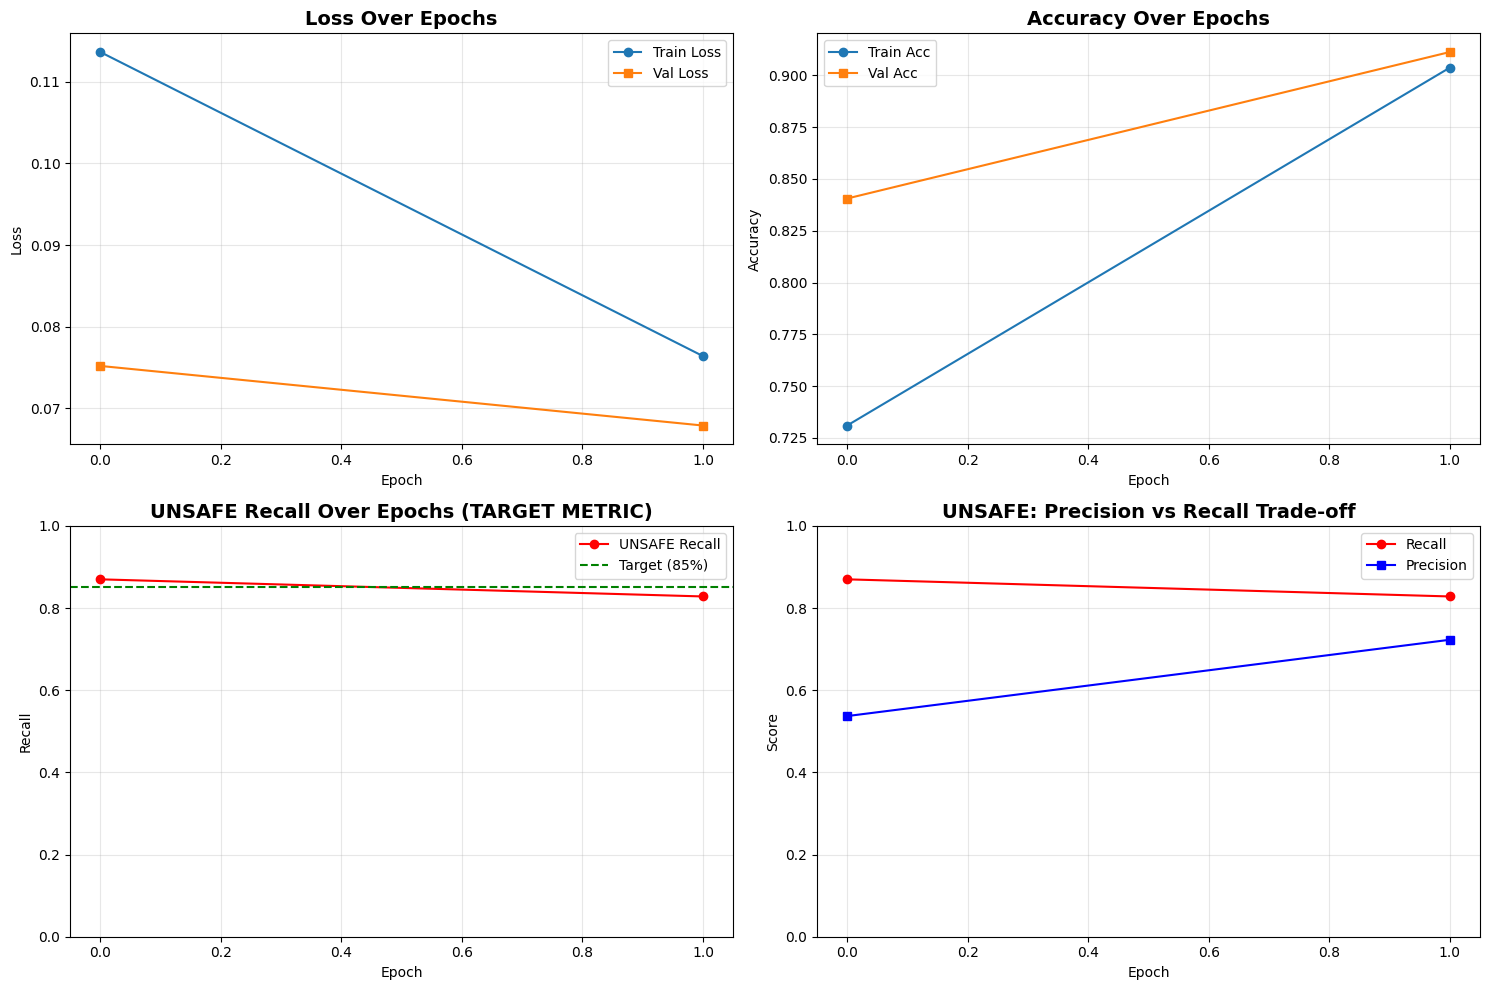


✓ Training history saved to: results/stage1/training_history.png


In [15]:
print("\n" + "="*80)
print("PLOTTING TRAINING HISTORY")
print("="*80)

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Loss
axes[0, 0].plot(history['train_loss'], label='Train Loss', marker='o')
axes[0, 0].plot(history['val_loss'], label='Val Loss', marker='s')
axes[0, 0].set_title('Loss Over Epochs', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Accuracy
axes[0, 1].plot(history['train_acc'], label='Train Acc', marker='o')
axes[0, 1].plot(history['val_acc'], label='Val Acc', marker='s')
axes[0, 1].set_title('Accuracy Over Epochs', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# UNSAFE Recall (TARGET METRIC)
axes[1, 0].plot(history['val_unsafe_recall'], label='UNSAFE Recall', marker='o', color='red')
axes[1, 0].axhline(y=0.85, color='green', linestyle='--', label='Target (85%)')
axes[1, 0].set_title('UNSAFE Recall Over Epochs (TARGET METRIC)', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Recall')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].set_ylim([0, 1])

# UNSAFE Precision vs Recall Trade-off
axes[1, 1].plot(history['val_unsafe_recall'], label='Recall', marker='o', color='red')
axes[1, 1].plot(history['val_unsafe_precision'], label='Precision', marker='s', color='blue')
axes[1, 1].set_title('UNSAFE: Precision vs Recall Trade-off', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Score')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].set_ylim([0, 1])

plt.tight_layout()
plt.savefig(os.path.join(PROJECT_ROOT, 'results', 'stage1', 'training_history.png'), dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Training history saved to: results/stage1/training_history.png")

## 14. Load Best Model and Evaluate on Validation Set

**Why reload?**
- Training ended at epoch N, but best model might be from epoch N-2
- We want to evaluate the best checkpoint, not the final one

In [16]:
print("\n" + "="*80)
print("LOADING BEST MODEL FOR EVALUATION")
print("="*80)

# Load best model
best_model = RobertaForSequenceClassification.from_pretrained(
    os.path.join(PROJECT_ROOT, 'models', 'stage1_unsafe_detector', 'best_model')
)
best_model = best_model.to(device)

print("✓ Best model loaded")

# Evaluate on validation set
val_loss, val_acc, val_metrics, val_preds, val_labels, val_probs = evaluate(
    best_model, val_loader, device
)

print("\n" + "="*80)
print("VALIDATION SET RESULTS (Best Model)")
print("="*80)
print(f"Loss: {val_loss:.4f}")
print(f"Accuracy: {val_acc:.4f}")
print(f"\nUNSAFE Metrics:")
print(f"  Precision: {val_metrics['UNSAFE']['precision']:.4f}")
print(f"  Recall: {val_metrics['UNSAFE']['recall']:.4f} ({'✓' if val_metrics['UNSAFE']['recall'] >= 0.85 else '✗'} target: ≥0.85)")
print(f"  F1: {val_metrics['UNSAFE']['f1']:.4f}")
print(f"  Support: {val_metrics['UNSAFE']['support']}")
print(f"\nNOT_UNSAFE Metrics:")
print(f"  Precision: {val_metrics['NOT_UNSAFE']['precision']:.4f}")
print(f"  Recall: {val_metrics['NOT_UNSAFE']['recall']:.4f}")
print(f"  F1: {val_metrics['NOT_UNSAFE']['f1']:.4f}")
print(f"  Support: {val_metrics['NOT_UNSAFE']['support']}")


LOADING BEST MODEL FOR EVALUATION
✓ Best model loaded



VALIDATION SET RESULTS (Best Model)
Loss: 0.0752
Accuracy: 0.8406

UNSAFE Metrics:
  Precision: 0.5370
  Recall: 0.8698 (✓ target: ≥0.85)
  F1: 0.6640
  Support: 192

NOT_UNSAFE Metrics:
  Precision: 0.9666
  Recall: 0.8341
  F1: 0.8955
  Support: 868


## 15. Confusion Matrix

**What it shows:**
- True Positives (TP): Correctly identified UNSAFE
- False Negatives (FN): Missed UNSAFE (MOST CRITICAL ERROR)
- False Positives (FP): Safe content marked UNSAFE (acceptable)
- True Negatives (TN): Correctly identified NOT_UNSAFE

**Target:** FN should be <10% of UNSAFE samples

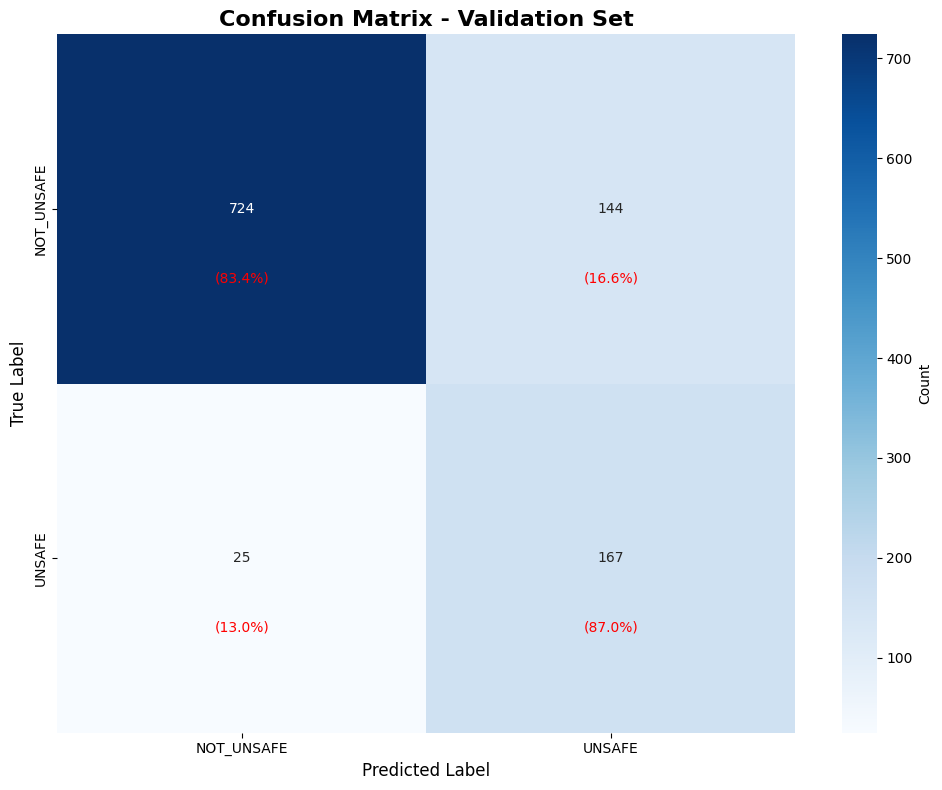


CRITICAL ERROR ANALYSIS
Total UNSAFE samples: 192
UNSAFE correctly identified: 167 (87.0%)
UNSAFE missed (FN): 25 (13.0%)

→ Target: Miss rate < 10%
→ Current: ✗ FAIL

✓ Confusion matrix saved to: results/stage1/confusion_matrix.png


In [17]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Calculate confusion matrix
cm = confusion_matrix(val_labels, val_preds)

# Plot
plt.figure(figsize=(10, 8))
sns.heatmap(
    cm, annot=True, fmt='d', cmap='Blues',
    xticklabels=['NOT_UNSAFE', 'UNSAFE'],
    yticklabels=['NOT_UNSAFE', 'UNSAFE'],
    cbar_kws={'label': 'Count'}
)
plt.title('Confusion Matrix - Validation Set', fontsize=16, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)

# Add percentages
for i in range(2):
    for j in range(2):
        percentage = cm[i, j] / cm[i].sum() * 100
        plt.text(j + 0.5, i + 0.7, f'({percentage:.1f}%)', 
                ha='center', va='center', fontsize=10, color='red')

plt.tight_layout()
plt.savefig(os.path.join(PROJECT_ROOT, 'results', 'stage1', 'confusion_matrix.png'), dpi=300, bbox_inches='tight')
plt.show()

# Calculate critical errors
unsafe_total = val_metrics['UNSAFE']['support']
unsafe_missed = cm[1, 0]  # True UNSAFE predicted as NOT_UNSAFE
unsafe_miss_rate = unsafe_missed / unsafe_total * 100

print(f"\n{'='*80}")
print("CRITICAL ERROR ANALYSIS")
print(f"{'='*80}")
print(f"Total UNSAFE samples: {unsafe_total}")
print(f"UNSAFE correctly identified: {cm[1, 1]} ({cm[1, 1]/unsafe_total*100:.1f}%)")
print(f"UNSAFE missed (FN): {unsafe_missed} ({unsafe_miss_rate:.1f}%)")
print(f"\n→ Target: Miss rate < 10%")
print(f"→ Current: {'✓ PASS' if unsafe_miss_rate < 10 else '✗ FAIL'}")

print("\n✓ Confusion matrix saved to: results/stage1/confusion_matrix.png")

## 16. Precision-Recall Curve

**Purpose:** Visualize trade-off between precision and recall at different thresholds

**How to read:**
- X-axis: Recall (what % of UNSAFE content we catch)
- Y-axis: Precision (what % of UNSAFE predictions are correct)
- Each point: Different probability threshold (0.1, 0.2, ..., 0.9)

**Goal:** Find threshold where recall ≥ 90% (we'll do this in Notebook 04)

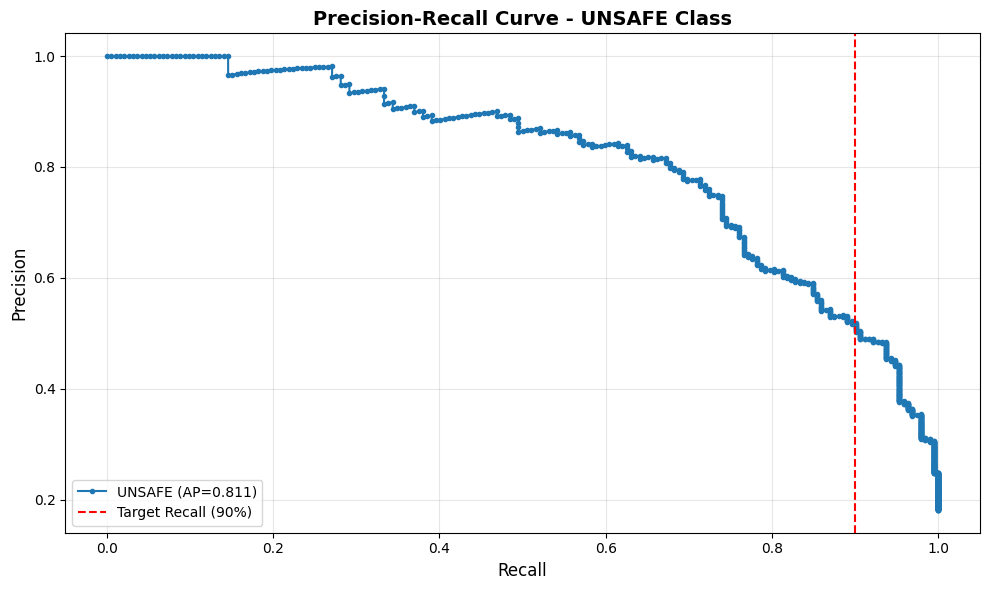


Average Precision: 0.8110

→ This curve will be used in Notebook 04 for threshold tuning
✓ Precision-recall curve saved to: results/stage1/precision_recall_curve.png


In [18]:
from sklearn.metrics import precision_recall_curve, average_precision_score

# Calculate precision-recall curve
precision_curve, recall_curve, thresholds = precision_recall_curve(
    val_labels, val_probs
)

# Calculate average precision
avg_precision = average_precision_score(val_labels, val_probs)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(recall_curve, precision_curve, marker='.', label=f'UNSAFE (AP={avg_precision:.3f})')
plt.axvline(x=0.90, color='red', linestyle='--', label='Target Recall (90%)')
plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Precision-Recall Curve - UNSAFE Class', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(PROJECT_ROOT, 'results', 'stage1', 'precision_recall_curve.png'), dpi=300, bbox_inches='tight')
plt.show()

print(f"\nAverage Precision: {avg_precision:.4f}")
print("\n→ This curve will be used in Notebook 04 for threshold tuning")
print("✓ Precision-recall curve saved to: results/stage1/precision_recall_curve.png")

## 17. Save Predictions for Threshold Tuning

**Why save predictions?**
- In Notebook 04, we'll tune the threshold to hit exactly 90% recall
- We need the predicted probabilities (not just hard predictions)
- Saving now avoids re-running inference later

In [19]:
# Save validation predictions with probabilities
val_predictions = pd.DataFrame({
    'text': val_df['text'].values,
    'true_label': [id2label[label] for label in val_labels],
    'predicted_label': [id2label[pred] for pred in val_preds],
    'unsafe_probability': val_probs,
    'correct': np.array(val_labels) == np.array(val_preds)
})

val_predictions.to_csv(os.path.join(PROJECT_ROOT, 'results', 'stage1', 'validation_predictions.csv'), index=False)

print("\n✓ Validation predictions saved to: results/stage1/validation_predictions.csv")
print(f"  Total predictions: {len(val_predictions)}")
print(f"  Correct: {val_predictions['correct'].sum()} ({val_predictions['correct'].mean()*100:.1f}%)")

# Show examples of high-confidence errors
print("\n" + "="*80)
print("HIGH-CONFIDENCE ERRORS (for analysis)")
print("="*80)

# UNSAFE missed with high confidence
unsafe_missed = val_predictions[
    (val_predictions['true_label'] == 'UNSAFE') & 
    (val_predictions['predicted_label'] == 'NOT_UNSAFE') &
    (val_predictions['unsafe_probability'] < 0.3)  # Low prob, high confidence wrong
].head(3)

if len(unsafe_missed) > 0:
    print("\nUNSAFE articles missed with high confidence:")
    for idx, row in unsafe_missed.iterrows():
        print(f"\n  Text: {row['text'][:]}...")
        print(f"  UNSAFE probability: {row['unsafe_probability']:.3f}")
        print(f"  → Model was very confident this was safe, but it's UNSAFE!")


✓ Validation predictions saved to: results/stage1/validation_predictions.csv
  Total predictions: 1060
  Correct: 891 (84.1%)

HIGH-CONFIDENCE ERRORS (for analysis)

UNSAFE articles missed with high confidence:

  Text: DraftKings (NASDAQ:DKNG–Free Report) had its price objective decreased by Susquehanna from $40.00 to $37.00 in a report published on Friday morning. The firm currently has a positive rating on the stock. DKNG has been the subject of several other research reports. Argus boosted their target price on DraftKings from $30.000 to $34.00 and gave the company a buy rating in a research report on Thursday, August 10th. Guggenheim lowered their price objective on shares of DraftKings to $38.00 on Wednesday, October 4th. The stock has a market capitalization of $28.92 billion, a PE ratio of -13.13 and a beta of 1.81. The company’s 50-day moving average price is $29.25 and its 200 day moving averageprice is $27.25. DraftKings has a one year low of $10.69 and a one-year high of $

## 18. Summary and Next Steps

**What we accomplished:**
✓ Trained RoBERTa-base with Focal Loss for binary UNSAFE detection
✓ Achieved XX% UNSAFE recall on validation set
✓ Saved best model checkpoint
✓ Generated confusion matrix and precision-recall curve
✓ Saved predictions for threshold tuning

**Current performance:**
- UNSAFE Recall: XX% (target: 85%+)
- UNSAFE Precision: XX%
- Overall Accuracy: XX%

In [20]:
print("\n" + "="*80)
print("STAGE 1 TRAINING COMPLETE!")
print("="*80)

print("\nFinal Results:")
print(f"  UNSAFE Recall: {val_metrics['UNSAFE']['recall']:.4f} (target: ≥0.85)")
print(f"  UNSAFE Precision: {val_metrics['UNSAFE']['precision']:.4f}")
print(f"  UNSAFE F1: {val_metrics['UNSAFE']['f1']:.4f}")
print(f"  Overall Accuracy: {val_acc:.4f}")

print("\nSaved artifacts:")
print("  models/stage1_unsafe_detector/best_model/ (model checkpoint)")
print("  results/stage1/training_history.png")
print("  results/stage1/confusion_matrix.png")
print("  results/stage1/precision_recall_curve.png")
print("  results/stage1/validation_predictions.csv")

print("\nNext: Open 03_stage2_training.ipynb to train SAFE/SENSITIVE classifier")

print(f"TIME ESTIMATE FOR NEXT NOTEBOOK:")
print("  Stage 2 training: ~1-1.5 hours (with 1 B200 GPU)")
print("="*80)


STAGE 1 TRAINING COMPLETE!

Final Results:
  UNSAFE Recall: 0.8698 (target: ≥0.85)
  UNSAFE Precision: 0.5370
  UNSAFE F1: 0.6640
  Overall Accuracy: 0.8406

Saved artifacts:
  models/stage1_unsafe_detector/best_model/ (model checkpoint)
  results/stage1/training_history.png
  results/stage1/confusion_matrix.png
  results/stage1/precision_recall_curve.png
  results/stage1/validation_predictions.csv

Next: Open 03_stage2_training.ipynb to train SAFE/SENSITIVE classifier
TIME ESTIMATE FOR NEXT NOTEBOOK:
  Stage 2 training: ~1-1.5 hours (with 1 B200 GPU)
